In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2024-03-07 15:49 (eradiate v0.25.1.dev31+g2a83b0ba.d20240229)*

Let's start by running a quick sample simulation. We use a hemispherical distant measure, which samples uniformly the hemisphere and stores radiance samples in a *film* data structure which maps the [0, 1]² space to the hemisphere. This coverage method is more efficient than uniform gridding of the (zenith, azimuth) space, but the output data can be tricky to manipulate and visualise.

In [2]:
%load_ext eradiate
import eradiate as ert
ert.set_mode("mono")

def run_exp(
    film_resolution=(32, 32),
    illumination_convention="east_right",
    measure_convention="east_right",
):
    exp = ert.experiments.AtmosphereExperiment(
        surface={"type": "rpv"},
        illumination={
            "type": "directional",
            "zenith": 30,
            "azimuth": 90,
            "azimuth_convention": illumination_convention,
        },
        measures={
            "type": "hdistant",
            "spp": 100000,
            "film_resolution": film_resolution,
            "azimuth_convention": measure_convention,
        },
    )
    return ert.run(exp).squeeze(drop=True)  # Squeeze and drop scalar dimensions

result = run_exp()

Mitsuba:   0%|          | 00:00, ETA=?

## Inspecting and preparing the dataset

The dataset itself has a comprehensive represention, which we can use to check what the data looks like. In the output of the following cell, pay attention to the *Dimensions* entry, then take a look at the dimensions associated with the `vza`, `vaa` and `radiance` variables.

In [3]:
result

<xarray.Dataset> Size: 42kB
Dimensions:     (y_index: 32, x_index: 32)
Coordinates:
  * y_index     (y_index) int64 256B 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    y           (y_index) float64 256B 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
  * x_index     (x_index) int64 256B 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    x           (x_index) float64 256B 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
    vza         (x_index, y_index) float64 8kB 86.47 86.47 86.47 ... 86.47 86.47
    vaa         (x_index, y_index) float64 8kB 225.0 222.1 219.2 ... 42.1 45.0
Data variables:
    radiance    (y_index, x_index) float64 8kB 0.2873 0.2918 ... 0.3015 0.2939
    brdf        (y_index, x_index) float64 8kB 0.1739 0.1766 ... 0.1824 0.1778
    brf         (y_index, x_index) float64 8kB 0.5462 0.5548 ... 0.5731 0.5587
    irradiance  float64 8B 1.652

In [4]:
result = result.transpose("y_index", "x_index")
result

<xarray.Dataset> Size: 42kB
Dimensions:     (y_index: 32, x_index: 32)
Coordinates:
  * y_index     (y_index) int64 256B 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    y           (y_index) float64 256B 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
  * x_index     (x_index) int64 256B 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    x           (x_index) float64 256B 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
    vza         (y_index, x_index) float64 8kB 86.47 86.47 86.47 ... 86.47 86.47
    vaa         (y_index, x_index) float64 8kB 225.0 227.9 230.8 ... 47.9 45.0
Data variables:
    radiance    (y_index, x_index) float64 8kB 0.2873 0.2918 ... 0.3015 0.2939
    brdf        (y_index, x_index) float64 8kB 0.1739 0.1766 ... 0.1824 0.1778
    brf         (y_index, x_index) float64 8kB 0.5462 0.5548 ... 0.5731 0.5587
    irradiance  float64 8B 1.652

## Visualising the film data

Now that our data layout is nice and uniform, we can take a look at is the film data itself. The plotting facilities offered by xarray are very convenient to get a quick overview:

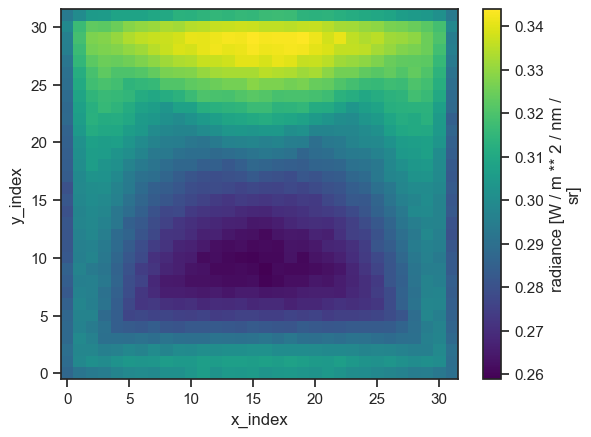

In [5]:
result.radiance.squeeze().plot.imshow()

This is not a great plot, but it is already useful for a quick check. We can see that the hotspot we would expect from the RPV surface we used is correctly position (zenith 30°, azimuth 90° in the East right convention). The dimension ordering we have chosen is arbitrary, but not entirely random: it guarantees that xarray will map the film width to the *x* axis. A major issue with this plot is that it does not have an equal aspect ratio for the *x* and *y* axes: pixels are not squares.

Let's build a cleaner plot. We will also add the viewing angles to see how they are mapped to the film.

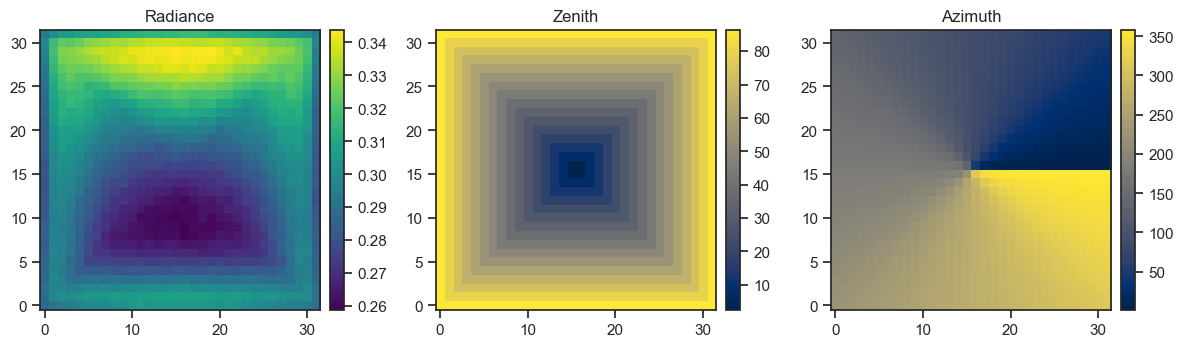

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_film(ds):
    fig, axs = plt.subplots(1, 3, figsize=(4*3, 4))

    for (var, title, cmap), ax in zip(
        [
            ["radiance", "Radiance", "viridis"], 
            ["vza", "Zenith", "cividis"], 
            ["vaa", "Azimuth", "cividis"],
        ],
        axs,
    ):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        im = ax.imshow(
            ds[var].values,
            aspect="equal",  # Important to get square pixels
            origin="lower",  # Position the origin as on the xarray plot
            cmap=cmap,
        )
        fig.colorbar(im, cax=cax)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()
    plt.close()
    
plot_film(result)

We enforced an equal aspect ratio for the *x* and *y* axes, and we can see that the viewing azimuth angles are mapped to film coordinates following with the East right convention.

## Gridded polar plots

Film coordinates are not the canonical representation for hemispherical data in Earth observation. Instead, scientists usually prefer polar representations. We can make polar plots with our film data with a little bit of effort.

In [7]:
import numpy as np
import eradiate.xarray

da = result.radiance.swap_dims(y_index="y", x_index="x")
da = da.ert.to_angular(
    theta=np.deg2rad(np.arange(0, 91, 5)),
    phi=np.deg2rad(np.arange(0, 360, 5)),
)
da

<xarray.DataArray (phi: 72, theta: 19)> Size: 11kB
0.2747 0.2746 0.275 0.2753 0.2755 0.2765 ... 0.2991 0.2996 0.2979 0.2923 0.2822
Coordinates:
  * phi      (phi) float64 576B 0.0 0.08727 0.1745 0.2618 ... 6.021 6.109 6.196
  * theta    (theta) float64 152B 0.0 0.08727 0.1745 ... 1.396 1.484 1.571

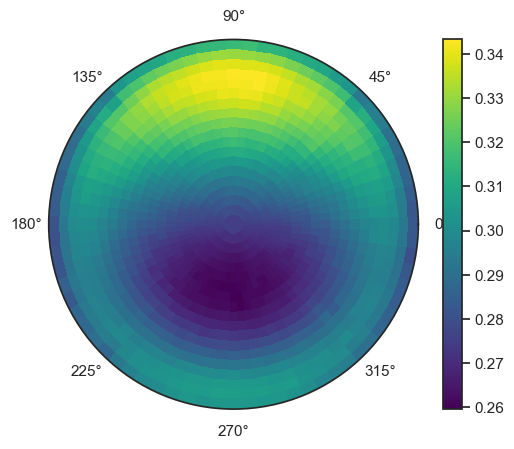

In [8]:
import numpy as np

def plot_polargrid(da):
    da = da.transpose("theta", "phi")  # Ensure appropriate data layout
    phi = da.phi.values  # Radian
    theta = np.rad2deg(da.theta.values)  # Degree
    values = da.values

    fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

    ax.grid(False)  # Hide the grid
    plt.pcolormesh(phi, theta, values, shading="nearest")
    plt.colorbar()
    ax.set_yticklabels([])  # No radial tick labels

    plt.show()
    plt.close()

plot_polargrid(da)

This method is costly because the gridding step interpolates the film data. However, it uses Matplotlib's polar plotting features, which make it easy to customise the final plot. We can, for instance, change the azimuth convention very easily.

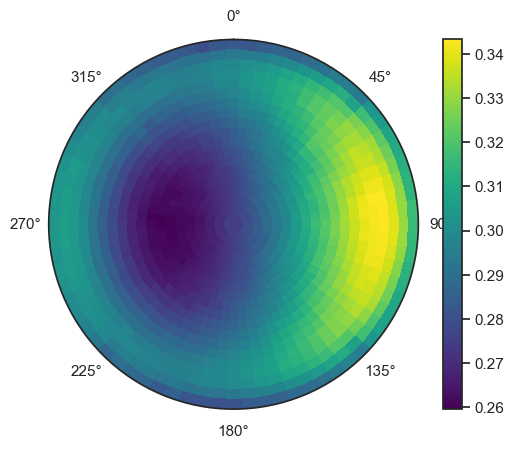

In [9]:
def plot_polargrid_north_left(da):
    da = da.transpose("theta", "phi")  # Ensure appropriate data layout
    phi = da.phi.values  # Radian
    theta = np.rad2deg(da.theta.values)  # Degree
    values = da.values

    fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

    ax.grid(False)  # Hide the grid
    plt.pcolormesh(phi, theta, values, shading="nearest")
    plt.colorbar()
    ax.set_yticklabels([])  # No radial tick labels
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)

    plt.show()
    plt.close()

plot_polargrid_north_left(da)

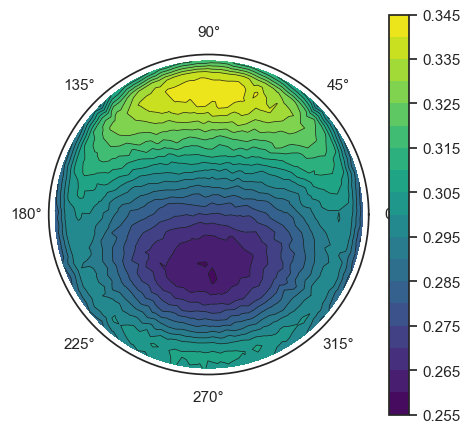

In [10]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri


def plot_polarfilm(ds, levels=16, show_contour=True, show_azimuth=False):
    radiances = ds.radiance.values.ravel()
    zeniths = ds.vza.values.ravel()  # Degree
    azimuths = np.deg2rad(ds.vaa.values).ravel()  # Radian

    # Create triangulation
    x = zeniths * np.cos(azimuths)
    y = zeniths * np.sin(azimuths)
    triangles = tri.Triangulation(x, y)
    
    # Make plot
    fig = plt.figure(0, figsize=(4, 4))
    rect = [0, 0, 1, 1]
    
    ## Main plot in Cartesian coordinates
    ax_cartesian = fig.add_axes(rect, aspect="equal")
    ax_cartesian.axis("off")  # Hide axis
    ctr = ax_cartesian.tricontourf(triangles, radiances, levels=levels, cmap="viridis")
    
    if show_contour:
        ax_cartesian.tricontour(triangles, radiances, levels=16, linewidths=0.5, colors="k")
    
    if show_azimuth:
        ax_cartesian.scatter(x, y, c=azimuths, cmap="plasma", s=3)

    ax_cartesian.set_xlim([-90, 90])  ## Match limits with the full zenith range
    ax_cartesian.set_ylim([-90, 90])
    
    ## Polar axes
    ax_polar = fig.add_axes(rect, polar=True, facecolor="none")
    ax_polar.set_rlim([0, 90]) # Cover the full zenith value range
    ax_polar.grid(False)  # Hide the polar grid
    ax_polar.set_yticklabels([])  # No radial tick labels
    
    # Add the color bar (important: both axes must be adjusted)
    fig.colorbar(ctr, ax=[ax_cartesian, ax_polar])

    plt.show()
    plt.close()
    
plot_polarfilm(result)

We can refine the levels to get a smoother colour map:

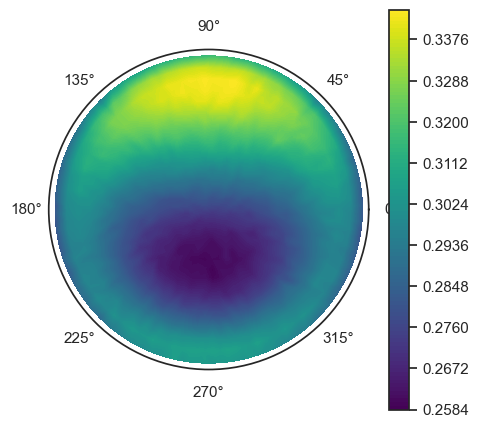

In [11]:
plot_polarfilm(result, levels=128, show_contour=False)

And we can also add the stored azimuth values:

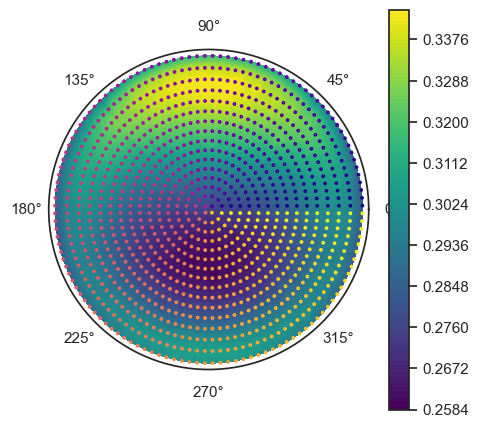

In [12]:
plot_polarfilm(result, levels=128, show_contour=False, show_azimuth=True)

Modifying the previous code to use the North left azimuth convention is similar to what we did for the gridded plot—with the important addition that angles must be transformed manually for the Cartesian part of the plot. The polar axes indeed display no data.

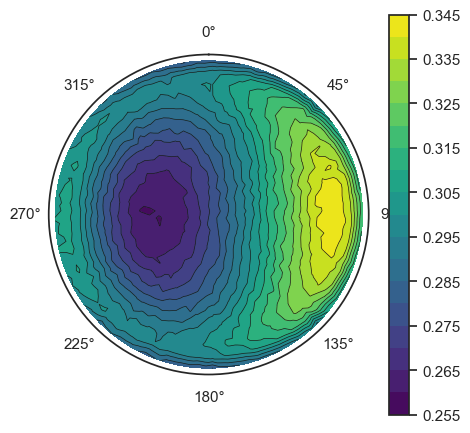

In [13]:
def plot_polarfilm_north_left(ds, levels=16, show_contour=True, show_azimuth=False):
    radiances = ds.radiance.values.ravel()
    zeniths = ds.vza.values.ravel()  # Degree
    azimuths = ert.frame.transform_azimuth(
        np.deg2rad(ds.vaa.values).ravel(), to_convention="north_left"
    )  # Radian

    # Create triangulation
    x = zeniths * np.cos(azimuths)
    y = zeniths * np.sin(azimuths)
    triangles = tri.Triangulation(x, y)
    
    # Make plot
    fig = plt.figure(0, figsize=(4, 4))
    rect = [0, 0, 1, 1]
    
    ## Main plot in Cartesian coordinates
    ax_cartesian = fig.add_axes(rect, aspect="equal")
    ax_cartesian.axis("off")  # Hide axis
    ctr = ax_cartesian.tricontourf(triangles, radiances, levels=levels, cmap="viridis")
    
    if show_contour:
        ax_cartesian.tricontour(triangles, radiances, levels=16, linewidths=0.5, colors="k")
    
    ax_cartesian.set_xlim([-90, 90])  ## Match limits with the full zenith range
    ax_cartesian.set_ylim([-90, 90])
    
    ## Polar axes
    ax_polar = fig.add_axes(rect, polar=True, facecolor="none")
    ax_polar.set_rlim([0, 90]) # Cover the full zenith value range
    ax_polar.grid(False)  # Hide the polar grid
    ax_polar.set_yticklabels([])  # No radial tick labels
    ax_polar.set_theta_direction(-1)
    ax_polar.set_theta_offset(np.pi / 2.0)
    
    # Add the color bar (important: both axes must be adjusted)
    fig.colorbar(ctr, ax=[ax_cartesian, ax_polar])

    plt.show()
    plt.close()
    
plot_polarfilm_north_left(result)